In [1]:
import numpy as np
import os
import pandas as pd
import pickle

from importlib import reload
from scipy.stats import gaussian_kde

import matplotlib as mpl
mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
import keras

Using Theano backend.


In [3]:
wdir = '/home/mho1/scratch/halo_cnn'

imdir = '/home/mho1/halo_cnn/paper_images'

In [4]:
from tools.catalog import Catalog

import tools.matt_tools as matt

reload(matt)

<module 'tools.matt_tools' from '/home/mho1/halo_cnn/notebooks/tools/matt_tools.py'>

# Compare models

In [23]:
c = ['g','b','r','y','m']

def compare_preds(model_list):
    
    
    f, ax = plt.subplots(figsize=(8,3))
    
    one_to_one = np.arange(13,16,0.1)
    ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')
    
    for i in range(len(model_list)):
        model = model_list[i]
        color = c[i]
        
        
        model_name = model[0] + '_' + str(model[1])
        data_dir = os.path.join(wdir, 'saved_models', model[0])
        cnn_dat = np.load(os.path.join(data_dir,  model_name, model_name + '.npy'), 
                encoding='latin1').item()
        cnn_par = cnn_dat['params']


        pred_err = cnn_dat['logmass_pred'] - cnn_dat['logmass_test']

        matt.binnedplot(cnn_dat['logmass_test'],pred_err,n=25, percentiles=[34], 
                        median=True, ax=ax, label=model[2],c=color, errorbar=False, 
                        names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)


    ax.set_xlim(xmin=cnn_dat['logmass_test'].min(), xmax=cnn_dat['logmass_test'].max())

    ax.set_ylim(ymin=-0.35,ymax=0.35)
    ax.set_ylabel(r'$\epsilon$',fontsize=14)
    ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

    plt.legend(ncol=4, loc=9, fontsize=10, 
               handletextpad=0.25, columnspacing=1#, handlelength=1.3
              )
    
    return f

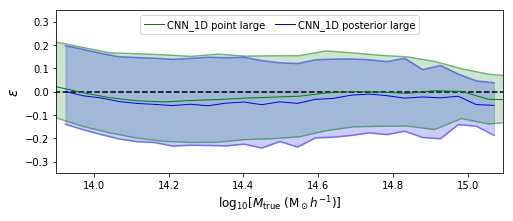

In [24]:
f = compare_preds([('halo_cnn1d_r', 156, 'CNN_1D point large'),
                   ('halo_cnn1d_rP', 3, 'CNN_1D posterior large')
                  ])
f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

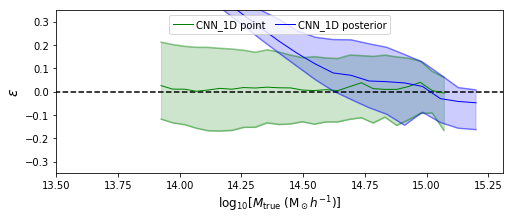

In [8]:
f = compare_preds([('halo_cnn1d_r', 152, 'CNN_1D point'),
                   ('halo_cnn1d_rP', 1, 'CNN_1D posterior')
                  ])

# f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

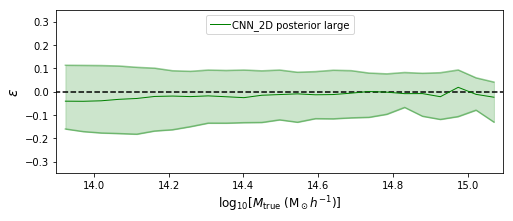

In [26]:
f = compare_preds([('halo_cnn2d_rP', 9, 'CNN_2D posterior large')
                  ])

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

# Shift Invariance

## Load Trained Models

In [44]:
model_1d_num = 152
model_2d_num =  67

In [45]:
# Load keras models

model_1d = [None]*10
model_2d = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(model_1d_num)+'/models/fold_'+str(i)+'.h5')
    model_2d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                           str(model_2d_num)+'/models/fold_'+str(i)+'.h5')

model_1d_np = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(153)+'/models/fold_'+str(0)+'.h5')
model_2d_np = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                      str(72)+'/models/fold_'+str(0)+'.h5')

fold: 0


/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [46]:
# Load params

par_1d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                 str(model_1d_num)+'/halo_cnn1d_r_' + \
                 str(model_1d_num) + '.npy',
                 encoding='latin1').item()['params']

par_2d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                 str(model_2d_num)+'/halo_cnn2d_r_' + \
                 str(model_2d_num) + '.npy',
                 encoding='latin1').item()['params']

def logM_from_y1d(y):
    return (par_1d['logmass_max'] - par_1d['logmass_min'])*y + par_1d['logmass_min']
def logM_from_y2d(y):
    return (par_2d['logmass_max'] - par_2d['logmass_min'])*y + par_2d['logmass_min']

## Load Catalog

In [47]:
cat_med = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_med.p'))
cat_lar = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam_large.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam_med.p
Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam_large.p


In [48]:
vcut = cat_med.par['vcut']
aperture = cat_med.par['aperture']

In [49]:
# Create test catalog

bin_edges = np.linspace(14,15.2, 35)
test_ind = []

for i in range(len(bin_edges)-1):
    test_ind += list( np.random.choice( np.argwhere( (cat_lar.prop['M200c']>10**bin_edges[i]) & \
                                                     (cat_lar.prop['M200c']<10**bin_edges[i+1])
                                                   ).flatten(), 5, replace=False ) )

## Calculate shift error, full cylinder

In [50]:
def cylinder_cut(gals, offset = (0,0)):
    
    members = (np.abs(gals['vlos'] - offset[0]) < vcut) & \
              ((gals['Rproj']-offset[1]) < aperture) & \
              ((gals['Rproj']-offset[1]) > 0)
    
    return gals[members]

def kde_1d(gals, offset=0):
    shape = (48,1)
    bwidth = 0.25
    vcut = 2500. # [km/s]
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0):
        warnings.warn('Zero vlos. Check if derived quantities have been updated.')
    
    v_pos = np.linspace(-vcut + offset ,vcut + offset, shape[0]+1)
    sample = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    
    kde = gaussian_kde(gals['vlos'], bwidth)
    
    kdeval = kde(sample).T
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

def kde_2d(gals, offset = (0,0)):
    shape=(48,48)
    bwidth=0.25
    vcut = 2500. # [km/s]
    aperture = 1.6 # [Mpc/h]
    
    v_pos = np.linspace(-vcut + offset[0], vcut + offset[0], shape[0] + 1)
    a_pos = np.linspace(0 + offset[1], aperture + offset[1], shape[1] + 1)
    v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()])
    
    
    kde = gaussian_kde((gals['vlos'],gals['Rproj']), bwidth)
    
    kdeval = np.reshape(kde(sample).T, mesh[0].shape)
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

### 1D

In [51]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut(cat_lar.gal[test_ind[k]])

    kdeval_1d = kde_1d(gals)

    logM_pred0_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    
# Determining offset predictions
diff_1d_p = np.zeros(shape=(48,))
diff_1d_np = np.zeros(shape=(48,))

for i in range(0,48):
    print(i)

    vlos_offset = (i-24)*(2*vcut)/48

    offset = (vlos_offset,0)

    logM_pred_p = np.zeros(len(test_ind))
    logM_pred_np = np.zeros(len(test_ind))

    for k in range(len(test_ind)):
        gals = cylinder_cut(cat_lar.gal[test_ind[k]], offset = offset)

        if len(gals)<3:
            continue

        kdeval_1d = kde_1d(gals, offset=offset[0])

        logM_pred_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
        logM_pred_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    diff_1d_p[i] = np.mean((logM_pred_p-logM_pred0_p)**2)
    diff_1d_np[i] = np.mean((logM_pred_np-logM_pred0_np)**2)

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
f = plt.figure(figsize=[4,4])

plt.plot(np.arange(-24,24), diff_1d_p,'b', label='With pooling')
plt.plot(np.arange(-24,24), diff_1d_np,'r', label='Without pooling')

plt.xlim(-24,24)
plt.ylim(0,1)
plt.xlabel('$v_\mathrm{los}$ pix')
plt.ylabel(r'$\langle\Delta\epsilon^2\rangle$')

plt.legend()

### 2D

In [17]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut(cat_lar.gal[test_ind[k]])

    kdeval_2d = kde_2d(gals)

    logM_pred0_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]

    
# Determining offset predictions
diff_2d_p = np.zeros(shape=(48,48))
diff_2d_np = np.zeros(shape=(48,48))

for i in range(0,48):
    for j in range(48):
        print((i,j))
        
        vlos_offset = (i-24)*(2*vcut)/48
        Rproj_offset = j*aperture/48
        
        offset = (vlos_offset, Rproj_offset)
        
        logM_pred_p = np.zeros(len(test_ind))
        logM_pred_np = np.zeros(len(test_ind))
        
        for k in range(len(test_ind)):
            gals = cylinder_cut(cat_lar.gal[test_ind[k]], offset = offset)
            
            if len(gals)<3:
                continue
            
            kdeval_2d = kde_2d(gals, offset=offset)
            
            logM_pred_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
            logM_pred_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]
        
        diff_2d_p[i,j] = np.mean((logM_pred_p-logM_pred0_p)**2)
        diff_2d_np[i,j] = np.mean((logM_pred_np-logM_pred0_np)**2)

NameError: name 'logM_from_y2d' is not defined

In [51]:
np.save(os.path.join(wdir,'temp','diff_2d_p.npy'), diff_2d_p)
np.save(os.path.join(wdir,'temp','diff_2d_np.npy'), diff_2d_np)

diff_2d_p_temp = np.load(os.path.join(wdir,'temp','diff_2d_p.npy'))
diff_2d_np_temp = np.load(os.path.join(wdir,'temp','diff_2d_np.npy'))

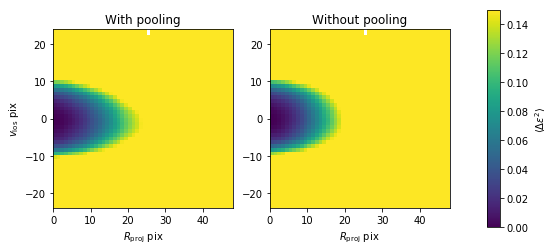

In [43]:
f = plt.figure(figsize=[8,4])
gs = mpl.gridspec.GridSpec(1,3, wspace=0.3,width_ratios=[7,7,0.5])


ax1 = f.add_subplot(gs[0,0])

im = ax1.imshow(diff_2d_p, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax1.set_title('With pooling')
ax1.set_xlabel('$R_\mathrm{proj}$ pix')
ax1.set_ylabel('$v_\mathrm{los}$ pix')

ax2 = f.add_subplot(gs[0,1])

im = ax2.imshow(diff_2d_np, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax2.set_xlabel('$R_\mathrm{proj}$ pix')
ax2.set_title('Without pooling')


ax3 = f.add_subplot(gs[0,2])
plt.colorbar(im,cax=ax3,label=r'$\langle\Delta\epsilon^2\rangle$')

## Calculate shift error, tight cylinder

In [52]:
v_maxshift = 12
aperture_maxshift = 20

vcut_tight = vcut *(24-v_maxshift)/24.
aperture_tight = aperture*(48-aperture_maxshift)/48.

def cylinder_cut_tight(gals, offset = (0,0)):
    
    members = (np.abs(gals['vlos'] - offset[0]) < vcut_tight) & \
              ((gals['Rproj']-offset[1]) < aperture_tight) & \
              ((gals['Rproj']-offset[1]) > 0)
    
    return gals[members]

def kde_2d(gals, offset = (0,0)):
    shape=(48,48)
    bwidth=0.25
    vcut = 2500. # [km/s]
    aperture = 1.6 # [Mpc/h]
    
    v_pos = np.linspace(-vcut + offset[0], vcut + offset[0], shape[0] + 1)
    a_pos = np.linspace(0 - offset[1], aperture - offset[1], shape[1] + 1)
    v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()])
    
    
    kde = gaussian_kde((gals['vlos'],gals['Rproj']), bwidth)
    
    kdeval = np.reshape(kde(sample).T, mesh[0].shape)
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


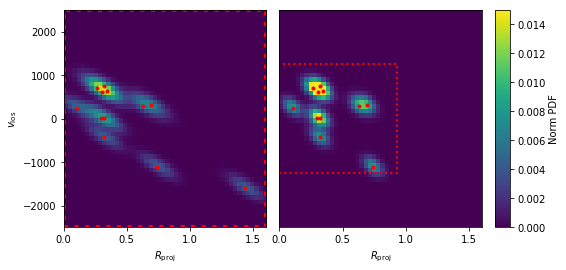

In [61]:
f = plt.figure(figsize=(8,4))
gs = mpl.gridspec.GridSpec(1,3, wspace=0.1,width_ratios=[7,7,0.5])


ax1 = f.add_subplot(gs[0,0])

gals = cylinder_cut(cat_lar.gal[0])
kdeval_2d = kde_2d(gals)

ax1.plot(gals['Rproj'],-gals['vlos'],'r.')
im = ax1.imshow(kdeval_2d.reshape(kdeval_2d.shape[1:]), 
                vmin=0, vmax=0.015,
                aspect='auto', extent=[0,aperture,-vcut,vcut])

ax1.add_patch(Rectangle((0,-vcut), aperture, 2*vcut, 
                        color='red', alpha=1, fill=False,
                        edgecolor='red', linestyle='dotted', linewidth=4
                       ))

ax1.set_xlabel('$R_\mathrm{proj}$')
ax1.set_ylabel('$v_\mathrm{los}$')

ax2 = f.add_subplot(gs[0,1])
gals = cylinder_cut_tight(cat_lar.gal[0])
kdeval_2d = kde_2d(gals)

ax2.plot(gals['Rproj'],-gals['vlos'],'r.')
im = ax2.imshow(kdeval_2d.reshape(kdeval_2d.shape[1:]), 
                vmin=0, vmax=0.015,
                aspect='auto', extent=[0,aperture,-vcut,vcut])

ax2.add_patch(Rectangle((0,-vcut_tight), aperture_tight, 2*vcut_tight, 
                        color='red', alpha=1,fill=False,
                        edgecolor='red', linestyle='dotted', linewidth=2
                       ))
ax2.set_yticks([])
ax2.set_xlabel('$R_\mathrm{proj}$')

ax3 = f.add_subplot(gs[0,2])
plt.colorbar(im,cax=ax3,label=r'Norm PDF')

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

### 1D

In [54]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut_tight(cat_lar.gal[test_ind[k]])

    kdeval_1d = kde_1d(gals)

    logM_pred0_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    
# Determining offset predictions
diff_1d_p = np.zeros(shape=(48,))
diff_1d_np = np.zeros(shape=(48,))

for i in np.arange(-v_maxshift,v_maxshift+1,dtype=int)+24:
    print(i)

    vlos_offset = (i-24)*(2*vcut)/48

    offset = (vlos_offset,0)

    logM_pred_p = np.zeros(len(test_ind))
    logM_pred_np = np.zeros(len(test_ind))

    for k in range(len(test_ind)):
        gals = cylinder_cut_tight(cat_lar.gal[test_ind[k]])#, offset = offset)

        if len(gals)<3:
            continue

        kdeval_1d = kde_1d(gals, offset=offset[0])

        logM_pred_p[k] = logM_from_y1d(model_1d[fold].predict(kdeval_1d)).flatten()[0]
        logM_pred_np[k] = logM_from_y1d(model_1d_np.predict(kdeval_1d)).flatten()[0]

    diff_1d_p[i] = np.mean((logM_pred_p-logM_pred0_p)**2)
    diff_1d_np[i] = np.mean((logM_pred_np-logM_pred0_np)**2)

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


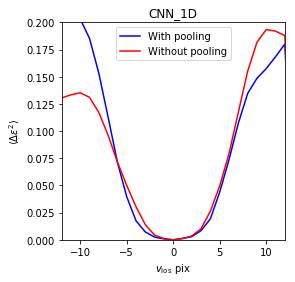

In [63]:
f = plt.figure(figsize=[4,4])

plt.plot(np.arange(-24,24), diff_1d_p,'b', label='With pooling')
plt.plot(np.arange(-24,24), diff_1d_np,'r', label='Without pooling')

plt.xlim(-v_maxshift,v_maxshift)
plt.ylim(0,0.2)
plt.xlabel('$v_\mathrm{los}$ pix')
plt.ylabel(r'$\langle\Delta\epsilon^2\rangle$')


plt.title('CNN_1D')
plt.legend()
f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

### 2D

In [56]:
fold = 0


# Determining baseline
logM_pred0_p = np.zeros(len(test_ind))
logM_pred0_np = np.zeros(len(test_ind))

for k in range(len(test_ind)):
    gals = cylinder_cut_tight(cat_lar.gal[test_ind[k]])

    kdeval_2d = kde_2d(gals)

    logM_pred0_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
    logM_pred0_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]

    
# Determining offset predictions
diff_2d_p = np.zeros(shape=(48,48))
diff_2d_np = np.zeros(shape=(48,48))

for i in np.arange(-v_maxshift,v_maxshift+1,dtype=int)+24:
    for j in range(aperture_maxshift):
        print((i,j))
        
        vlos_offset = (i-24)*(2*vcut)/48
        Rproj_offset = j*aperture/48
        
        offset = (vlos_offset, Rproj_offset)
        
        logM_pred_p = np.zeros(len(test_ind))
        logM_pred_np = np.zeros(len(test_ind))
        
        for k in range(len(test_ind)):
            gals = cylinder_cut_tight(cat_lar.gal[test_ind[k]])#, offset = offset)
            
            if len(gals)<3:
                continue
            
            kdeval_2d = kde_2d(gals, offset=offset)
            
            logM_pred_p[k] = logM_from_y2d(model_2d[fold].predict(kdeval_2d)).flatten()[0]
            logM_pred_np[k] = logM_from_y2d(model_2d_np.predict(kdeval_2d)).flatten()[0]
        
        diff_2d_p[i,j] = np.mean((logM_pred_p-logM_pred0_p)**2)
        diff_2d_np[i,j] = np.mean((logM_pred_np-logM_pred0_np)**2)

(12, 0)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(12, 9)
(12, 10)
(12, 11)
(12, 12)
(12, 13)
(12, 14)
(12, 15)
(12, 16)
(12, 17)
(12, 18)
(12, 19)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 5)
(13, 6)
(13, 7)
(13, 8)
(13, 9)
(13, 10)
(13, 11)
(13, 12)
(13, 13)
(13, 14)
(13, 15)
(13, 16)
(13, 17)
(13, 18)
(13, 19)
(14, 0)
(14, 1)
(14, 2)
(14, 3)
(14, 4)
(14, 5)
(14, 6)
(14, 7)
(14, 8)
(14, 9)
(14, 10)
(14, 11)
(14, 12)
(14, 13)
(14, 14)
(14, 15)
(14, 16)
(14, 17)
(14, 18)
(14, 19)
(15, 0)
(15, 1)
(15, 2)
(15, 3)
(15, 4)
(15, 5)
(15, 6)
(15, 7)
(15, 8)
(15, 9)
(15, 10)
(15, 11)
(15, 12)
(15, 13)
(15, 14)
(15, 15)
(15, 16)
(15, 17)
(15, 18)
(15, 19)
(16, 0)
(16, 1)
(16, 2)
(16, 3)
(16, 4)
(16, 5)
(16, 6)
(16, 7)
(16, 8)
(16, 9)
(16, 10)
(16, 11)
(16, 12)
(16, 13)
(16, 14)
(16, 15)
(16, 16)
(16, 17)
(16, 18)
(16, 19)
(17, 0)
(17, 1)
(17, 2)
(17, 3)
(17, 4)
(17, 5)
(17, 6)
(17, 7)
(17, 8)
(17, 9)
(17, 10)
(17, 11)
(17, 12)
(17, 13)
(17, 14)
(17, 15)
(17, 16)
(17, 17

In [57]:
np.save(os.path.join(wdir,'temp','diff_2d_p_tight.npy'), diff_2d_p)
np.save(os.path.join(wdir,'temp','diff_2d_np_tight.npy'), diff_2d_np)

diff_2d_p_temp = np.load(os.path.join(wdir,'temp','diff_2d_p_tight.npy'))
diff_2d_np_temp = np.load(os.path.join(wdir,'temp','diff_2d_np_tight.npy'))

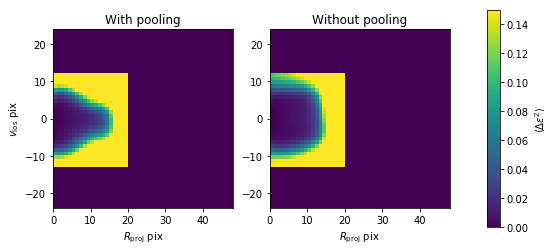

In [64]:
f = plt.figure(figsize=[8,4])
gs = mpl.gridspec.GridSpec(1,3, wspace=0.3,width_ratios=[7,7,0.5])


ax1 = f.add_subplot(gs[0,0])

im = ax1.imshow(diff_2d_p, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax1.set_title('With pooling')
ax1.set_xlabel('$R_\mathrm{proj}$ pix')
ax1.set_ylabel('$v_\mathrm{los}$ pix')

ax2 = f.add_subplot(gs[0,1])

im = ax2.imshow(diff_2d_np, extent=[0,48,-24,24], vmin=0, vmax=0.15)

ax2.set_xlabel('$R_\mathrm{proj}$ pix')
ax2.set_title('Without pooling')


ax3 = f.add_subplot(gs[0,2])
plt.colorbar(im,cax=ax3,label=r'$\langle\Delta\epsilon^2\rangle$')

f.savefig(os.path.join(imdir,'temp.png'),bbox_inches='tight', dpi=500)

# Binned Posterior

## 2D Output

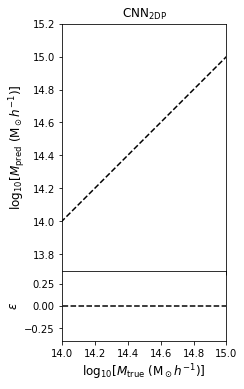

In [59]:
model_name = 'halo_cnn2d_rP'
model_num = 3

data_dir = os.path.join(wdir, 'saved_models', model_name)
model_name_save = model_name + '_' + str(model_num)

cnn_dat = np.load(os.path.join(data_dir, model_name_save, model_name_save + '.npy'), 
                encoding='latin1').item()
cnn_par = cnn_dat['params']

one_to_one = np.arange(11)*(cnn_par['logmass_max'] - cnn_par['logmass_min'])/10. + cnn_par['logmass_min']

f = plt.figure(figsize=[3.5,6])
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[4,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])
ax1.plot(one_to_one,one_to_one, color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'], cnn_dat['logmass_pred'], n=20, 
            percentiles=[34,47], median=True, ax=ax1, log=0, c='g'
            )
ax1.set_ylabel(r'$\log_{10}[M_\mathrm{pred}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

ax1.set_xticklabels([])
ax1.set_xlim(xmin=14, xmax=15)
ax1.set_ylim(ymin=13.7, ymax=15.2)
ax1.set_aspect(aspect='equal',adjustable='box', anchor='S')


# pred_err = (10.**cnn_dat['logmass_pred'])/(10.**cnn_dat['logmass_test']) - 1.
pred_err = cnn_dat['logmass_pred'] - cnn_dat['logmass_test']

ax2 = f.add_subplot(gs[1,0])# , sharex=ax1)
ax2.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

matt.binnedplot(cnn_dat['logmass_test'],pred_err,n=20, percentiles=[34, 47], 
                median=True, ax=ax2, label='cnn',c='g', errorbar=False, names=False, log=0)

ax2.set_xlim(xmin=14, xmax=15)

ax2.set_ylim(ymin=-0.4,ymax=0.4)
ax2.set_ylabel(r'$\epsilon$',fontsize=12)
ax2.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

# ax2.set_yticklabels([-0.5,0,1])


ax1.set_title('CNN$_\mathrm{2DP}$', fontsize=12)

plt.tight_layout()

# f.savefig(os.path.join(imdir,'pred_1d.pdf'),bbox_inches='tight', dpi=300)

In [59]:
cnn_dat['logmass_test']

array([13.900006, 13.900006, 13.900006, ..., 15.092018, 15.092686,
       15.094051], dtype=float32)

In [16]:
cnn_dat['logmass_pred']

array([13.50062084, 13.50062084, 13.50062084, ..., 13.50062084,
       13.50062084, 13.50062084])

# Redshift dependence

## Load Trained Models

In [27]:
model_1d_num = 157# 152
model_2d_num =  76# 67

In [28]:
# Load keras models

model_1d = [None]*10
model_2d = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(model_1d_num)+'/models/fold_'+str(i)+'.h5')
    model_2d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                           str(model_2d_num)+'/models/fold_'+str(i)+'.h5')

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [29]:
# Load params

par_1d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                 str(model_1d_num)+'/halo_cnn1d_r_' + \
                 str(model_1d_num) + '.npy',
                 encoding='latin1').item()['params']

par_2d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                 str(model_2d_num)+'/halo_cnn2d_r_' + \
                 str(model_2d_num) + '.npy',
                 encoding='latin1').item()['params']

def logM_from_y1d(y):
    y = (y+1)/2.
    return (par_1d['logmass_max'] - par_1d['logmass_min'])*y + par_1d['logmass_min']
def logM_from_y2d(y):
    y = (y+1)/2.
    return (par_2d['logmass_max'] - par_2d['logmass_min'])*y + par_2d['logmass_min']

## Predict on redshift bin

### CNN_1D

In [30]:
z_list = [0.000,0.045,0.117,0.194,0.248]


data_path = os.path.join(wdir, 'data_processed', 'halo_cnn1d_r')

mass_preds = {}



for z in z_list:
    print(z)
    with open(os.path.join(data_path, 'halo_cnn1d_r_z=' +'%.3f'%z+ '.p'), 'rb') as f:
        data_proc = pickle.load(f)['data']
    
    in_dat = data_proc['pdf'][data_proc['in_test']==1]
    in_dat = np.reshape(in_dat, (*(in_dat.shape),1))
    
    pred_temp = logM_from_y1d(model_1d[0].predict(in_dat)).flatten()
    for i in range(1,10):
        pred_temp += logM_from_y1d(model_1d[i].predict(in_dat)).flatten()
    
    pred_temp/=10.
        
    mass_preds[z] = (pred_temp,
                     data_proc['logmass'][data_proc['in_test']==1]
                    )

0.0
0.045
0.117
0.194
0.248


### CNN_2D

In [35]:
z_list = [0.000,0.045,0.117,0.194,0.248]


data_path = os.path.join(wdir, 'data_processed', 'halo_cnn2d_r')

mass_preds = {}



for z in z_list:
    print(z)
    with open(os.path.join(data_path, 'halo_cnn2d_r_z=' +'%.3f'%z+ '.p'), 'rb') as f:
        data_proc = pickle.load(f)['data']
    
    pred_temp = logM_from_y2d(model_2d[0].predict(data_proc['pdf'][data_proc['in_test']==1])).flatten()
    
    for i in range(1,10):
        pred_temp += logM_from_y2d(model_2d[i].predict(data_proc['pdf'][data_proc['in_test']==1])).flatten()
    
    pred_temp/=10.
        
    mass_preds[z] = (pred_temp,
                     data_proc['logmass'][data_proc['in_test']==1]
                    )

0.0
0.045
0.117
0.194
0.248


## Plot

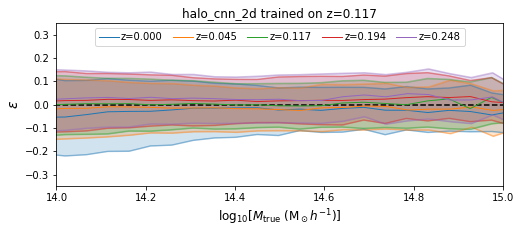

In [40]:
f, ax = plt.subplots(figsize=(8,3))
    
one_to_one = np.arange(13,16,0.1)
ax.plot(one_to_one,[0]*len(one_to_one), color='k', linestyle='dashed')

for z in z_list:
    err = mass_preds[z][0] - mass_preds[z][1]
    
    matt.binnedplot(mass_preds[z][1], err,n=25, percentiles=[34], 
                    median=True, ax=ax, label='z=%.3f'%z, errorbar=False, 
                    names=False, log=0, linestyle='-', err_lines=True, lw=1., alpha=0.2)


ax.set_xlim(xmin=14, xmax=15)

ax.set_ylim(ymin=-0.35,ymax=0.35)
ax.set_ylabel(r'$\epsilon$',fontsize=14)
ax.set_xlabel(r'$\log_{10}[M_\mathrm{true}\ (\mathrm{M}_\odot h^{-1})$]',fontsize=12)

plt.legend(ncol=5, loc=9, fontsize=10, 
           handletextpad=0.25, columnspacing=1#, handlelength=1.3
          )

plt.title('halo_cnn_2d trained on z=0.117')

f.savefig(os.path.join(imdir,'temp.png'),dpi=300, bbox_inches='tight')

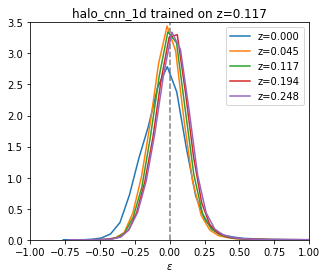

In [41]:
f, ax = plt.subplots(figsize=(5,4))

plt.axvline(0,c='k',linestyle='--',alpha=0.5)

for z in z_list:
    err = mass_preds[z][0] - mass_preds[z][1]
    
    H, bin_edges = np.histogram(err, bins=30, density=True)
    
    plt.plot([np.mean((bin_edges[i],bin_edges[i+1]))  for i in range(len(bin_edges)-1)],
             H,
             label='z=%.3f'%z)

plt.xlim(-1,1)
plt.ylim(0,3.5)
plt.xlabel('$\epsilon$')
plt.title('halo_cnn_1d trained on z=0.117')
plt.legend()

f.savefig(os.path.join(imdir,'temp.png'),dpi=300, bbox_inches='tight')

# Scratch

(array([100., 101.,  90., 103.,  91., 104., 100., 124.,  88.,  99.]),
 array([0.05, 0.14, 0.23, 0.32, 0.41, 0.5 , 0.59, 0.68, 0.77, 0.86, 0.95]),
 <a list of 10 Patch objects>)

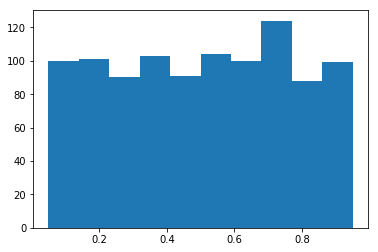

In [33]:
Y_point = np.random.rand(1000)

Y = np.zeros(shape=(len(Y_point), 10), dtype=int)

bin_edges = np.linspace(0, 1, 10+1)
for i in range(10):
    Y[:,i] = (Y_point >= bin_edges[i]) & (Y_point <= bin_edges[i+1])
    
bin_centers = [np.mean((bin_edges[i],bin_edges[i+1])) for i in range(10)]

# print(Y)
plt.hist(np.dot(Y,bin_centers))

In [21]:
par = {'nbins':10}

# Managing posterior model output
bin_edges = np.linspace(0, 1, par['nbins']+1)
def y_to_bins(y_point):
    y_binned = np.zeros(shape=(len(y_point), par['nbins']), dtype=int)

    for i in range(par['nbins']):
        y_binned[:,i] = (y_point >= bin_edges[i]) & (y_point <= bin_edges[i+1])
        
    return y_binned


bin_centers = [np.mean((bin_edges[i],bin_edges[i+1])) for i in range(par['nbins'])]
def bins_to_y(y_binned):
    y_point = np.dot(y_binned, bin_centers)
    
    return y_point

In [22]:
bins_to_y(y_to_bins(np.arange(0,1,0.11)))

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [23]:
model_2d_rP = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_rP/halo_cnn2d_rP_' + \
                                      str(3)+'/models/fold_'+str(0)+'.h5')

<BarContainer object of 10 artists>

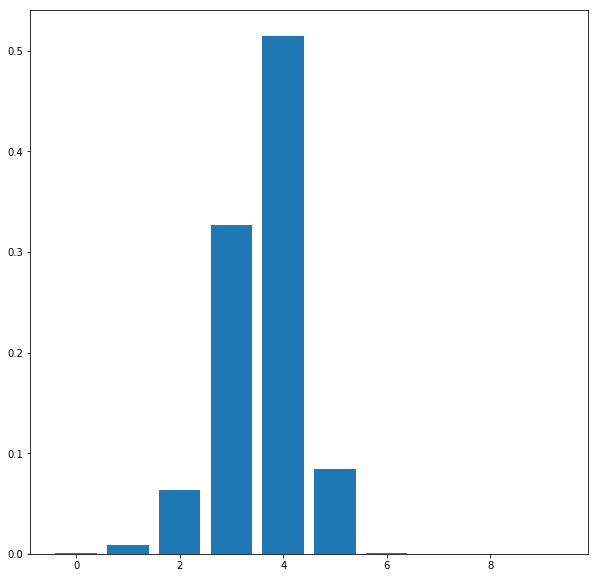

In [24]:
plt.bar(x=np.arange(10),height=model_2d_rP.predict(kdeval_2d)[0])

In [25]:
bins_to_y(model_2d_rP.predict(kdeval_2d))

array([0.40989323])

In [26]:
bins_to_y(model_2d_rP.predict(np.array([kdeval_2d[0]]*100)))

array([0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989326,
       0.40989326, 0.40989326, 0.40989326, 0.40989326, 0.40989

In [58]:
model_2d_rP.predict(kdeval_2d)

array([[1.5702060e-01, 5.9180325e-01, 2.4255335e-01, 8.5795950e-03,
        4.2743468e-05, 4.2549382e-09, 2.2720393e-11, 6.1262490e-08,
        3.6527487e-07, 3.0047175e-13]], dtype=float32)